<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Functions-and-Classes" data-toc-modified-id="Functions-and-Classes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions and Classes</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Loading-Images-and-Captions" data-toc-modified-id="Loading-Images-and-Captions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Loading Images and Captions</a></span></li><li><span><a href="#Split:-Train-and-Test" data-toc-modified-id="Split:-Train-and-Test-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Split: Train and Test</a></span></li><li><span><a href="#Batchs-de-Zips" data-toc-modified-id="Batchs-de-Zips-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Batchs de Zips</a></span></li><li><span><a href="#Get-bucket-metadata" data-toc-modified-id="Get-bucket-metadata-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Get bucket metadata</a></span></li><li><span><a href="#List-blobs-in-a-bucket" data-toc-modified-id="List-blobs-in-a-bucket-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>List blobs in a bucket</a></span></li><li><span><a href="#Save-Model-Parameters" data-toc-modified-id="Save-Model-Parameters-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Save Model Parameters</a></span></li></ul></div>

# Image Captioning - Advanced Statistics Topics

In this notebook, we train several models and save the results of its metrics.

## Import Libraries

In this section we import the requiere libraries and establish the connection with Google Drive.

In [1]:
# Se importan las librerias necesarias
import numpy as np
import pandas as  pd
import os
import gzip
import timeit
import json
import collections
import zipfile
import random
import pickle
import time
from PIL import Image
from tqdm import tqdm
# from google.colab import drive # Necesario para GoogleColab

# Tensorflow 2.x
import tensorflow as tf # Not required for this notebook 
print('TENSORFLOW VERSION: {}'.format(tf.__version__))

TENSORFLOW VERSION: 2.2.0


In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
# Se fija el directorio referencia con el se conecta colab a drive # Necesario para GoogleColab
# drive.mount('/content/drive', force_remount=True)

In [4]:
# Se guarda en una variable el directorio del curso

# Directorio de los datos
data_folder = '../Data/'
#os.chdir('drive/MyDrive/Colab Notebooks/AST-ImageCaptioning/Notebooks/')

## Functions and Classes

In [5]:
# Load an image and adjust it to InceptionV3 networks
def image_to_v3_format(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Data Preprocessing

In this section we process the images and its respective captions.

In [6]:
# Download caption annotation files
annotation_folder = data_folder + '/Captions/'
if not os.path.exists(os.path.abspath('.') + '/' + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                              cache_subdir=os.path.abspath('.') + '/' + data_folder,
                              origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                              extract=True)
    os.rename(data_folder + 'annotations/', annotation_folder)
    annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'
    os.remove(annotation_zip)

In [7]:
# Download image files
image_folder = data_folder + 'Images/'
if not os.path.exists(os.path.abspath('.') + '/' + image_folder):
    image_zip = tf.keras.utils.get_file('Train.zip',
                                      cache_subdir=os.path.abspath('.') + '/' + image_folder,
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
#     os.rename(image_folder + 'train2014/', image_folder + 'Train/') # Better to change the name directly
    PATH = image_folder + 'Train/'
    os.remove(image_zip)
else:
    PATH = image_folder + 'Train/'

## Loading Images and Captions

In [8]:
# Process all the captions
with open(annotation_folder + 'captions_train2014.json', 'r') as f:
    captions = json.load(f)
    
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in captions['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [9]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths.copy()#[:15000]
print('THE NUMBER OF IMAGES IS {} AND THERE IS {} CAPTIONS'.format(len(train_image_paths), len(captions['annotations'])))

THE NUMBER OF IMAGES IS 82783 AND THERE IS 414113 CAPTIONS


In [10]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

Caption: <start> a person on a horse jumps over an obstacle  <end>


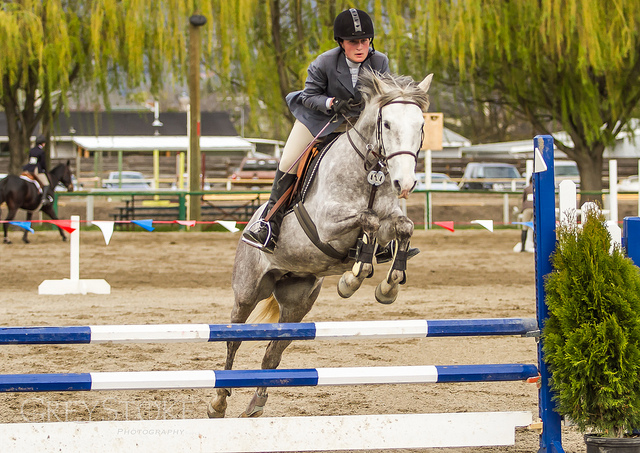

In [11]:
sample_image = 1608
print('Caption:', train_captions[sample_image])
Image.open(img_name_vector[sample_image])

In [12]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [13]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# It can be done for big batches because our vm has 128gb of ram
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(image_to_v3_format, num_parallel_calls=4).batch(2**6)

In [14]:
if not os.path.exists(os.path.abspath('.') + '/' + image_folder + 'InceptionV3/'):
    os.makedirs(os.path.abspath('.') + '/' + image_folder + 'InceptionV3/')
    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            path_of_feature = path_of_feature.split('/')[-1]
            np.save(image_folder + 'InceptionV3/' + path_of_feature, bf.numpy())
        del batch_features, bf, p, img, path

In [15]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split: Train and Test

In [16]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.6)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [17]:
print('NUMBER OF TRAIN IMAGES: {} AND NUMBER OF TRAIN CAPTIONS: {}'.format(len(img_name_train), len(cap_train)))
print('NUMBER OF TEST IMAGES: {} AND NUMBER OF TEST CAPTIONS: {}'.format(len(img_name_val), len(cap_val)))

NUMBER OF TRAIN IMAGES: 331274 AND NUMBER OF TRAIN CAPTIONS: 331274
NUMBER OF TEST IMAGES: 82839 AND NUMBER OF TEST CAPTIONS: 82839


In [18]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 500
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [19]:
# Load the numpy files
def map_func(img_name, cap):
    img_new_name = image_folder + 'InceptionV3/' + img_name.decode('utf-8').split('/')[-1]
    img_new_name = str.encode(img_new_name)
    img_tensor = np.load(img_new_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [23]:
random.Random(1608).shuffle(img_name_train)
random.Random(1608).shuffle(cap_train)

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=4)

# Shuffle and batch
dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#dataset = dataset.prefetch(buffer_size=500)

In [24]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [26]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [29]:
checkpoint_path = "../Data/TrainCheckpoints/TrainType0/"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [31]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [32]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 10 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}', end='\r')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss/
                     num_steps)

    if epoch % 1 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}', end='\n')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n', end='\n')

Epoch 1 Loss 0.675340ss 0.6068
Time taken for 1 epoch 1041.52 sec



KeyboardInterrupt: 

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

## Batchs de Zips

In [59]:
batches = 50
total_train_keys = len(img_name_train_keys)
try:
    os.mkdir('../Data/Images/Zips/')
except:
    pass

for idx in range(batches):
    lim_inf = (idx)*(total_train_keys // batches)
    lim_sup = (idx+1)*(total_train_keys // batches)
    if idx == (batches-1):
        lim_s4up = total_train_keys
    files_to_zip = img_name_train_keys[lim_inf:lim_sup]
    with zipfile.ZipFile('../Data/Images/Zips/ZipBatch_{}.zip'.format(idx), 'w') as zipMe:        
        for file in files_to_zip:
            zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)
    if (idx+1) % 5 == 0:
        print('Batch Number {} Processed'.format(idx+1), '\r')

Batch Number 5 Processed 
Batch Number 10 Processed 
Batch Number 15 Processed 
Batch Number 20 Processed 
Batch Number 25 Processed 
Batch Number 30 Processed 
Batch Number 35 Processed 
Batch Number 40 Processed 
Batch Number 45 Processed 
Batch Number 50 Processed 


In [20]:
files_to_zip = os.listdir('../Data/Images/Zips/')
with zipfile.ZipFile('../Data/Images/SuperTrainZip.zip', 'w') as zipMe:        
    for file in files_to_zip:
        zipMe.write('../Data/Images/Zips/' + file, compress_type=zipfile.ZIP_DEFLATED)
        print(file)

ZipBatch_33.zip
ZipBatch_43.zip
ZipBatch_7.zip
ZipBatch_44.zip
ZipBatch_10.zip
ZipBatch_35.zip
ZipBatch_2.zip
ZipBatch_46.zip
ZipBatch_38.zip
ZipBatch_30.zip
ZipBatch_40.zip
ZipBatch_19.zip
ZipBatch_16.zip
ZipBatch_3.zip
ZipBatch_34.zip
ZipBatch_42.zip
ZipBatch_1.zip
ZipBatch_31.zip
ZipBatch_29.zip
ZipBatch_36.zip
ZipBatch_14.zip
ZipBatch_8.zip
ZipBatch_20.zip
ZipBatch_22.zip
ZipBatch_17.zip
ZipBatch_28.zip
ZipBatch_13.zip
ZipBatch_37.zip
ZipBatch_0.zip
ZipBatch_27.zip
ZipBatch_47.zip
ZipBatch_26.zip
ZipBatch_11.zip
ZipBatch_21.zip
ZipBatch_39.zip
ZipBatch_49.zip
ZipBatch_12.zip
ZipBatch_45.zip
ZipBatch_41.zip
ZipBatch_23.zip
ZipBatch_6.zip
ZipBatch_24.zip
ZipBatch_4.zip
ZipBatch_25.zip
ZipBatch_18.zip
ZipBatch_32.zip
ZipBatch_9.zip
ZipBatch_15.zip
ZipBatch_48.zip
ZipBatch_5.zip


In [21]:
from google.cloud import storage

The `storage.Client` object uses your default project. Alternatively, you can specify a project in the `Client` constructor. For more information about how the default project is determined, see the [google-auth documentation](https://google-auth.readthedocs.io/en/latest/reference/google.auth.html).

Run the following to create a client with your default project:

In [22]:
client = storage.Client()
print("Client created using default project: {}".format(client.project))

Client created using default project: imagecaptioning-311723


To explicitly specify a project when constructing the client, set the `project` parameter:

In [23]:
buckets = client.list_buckets()

print("Buckets in {}:".format(client.project))
for item in buckets:
    print("\t" + item.name)

Buckets in imagecaptioning-311723:
	image-captioning-data


## Get bucket metadata

The next cell shows how to get information on metadata of your Cloud Storage buckets.

To learn more about specific bucket properties, see [Bucket locations](https://cloud.google.com/storage/docs/locations) and [Storage classes](https://cloud.google.com/storage/docs/storage-classes).

In [24]:
bucket_name = 'image-captioning-data'
bucket = client.get_bucket(bucket_name)

print("Bucket name: {}".format(bucket.name))
print("Bucket location: {}".format(bucket.location))
print("Bucket storage class: {}".format(bucket.storage_class))

Bucket name: image-captioning-data
Bucket location: US-EAST1
Bucket storage class: STANDARD


In [26]:
blob_name = "images/SuperTrainZip.zip"
blob = bucket.blob(blob_name)

source_file_name = "../Data/Images/SuperTrainZip.zip" 
blob.upload_from_filename(source_file_name)

print("File uploaded to {}.".format(bucket.name))

File uploaded to image-captioning-data.


## List blobs in a bucket

In [ ]:
blobs = bucket.list_blobs()

print("Blobs in {}:".format(bucket.name))
for item in blobs:
    print("\t" + item.name)

## Save Model Parameters

In [24]:
parameters = {
    'MAX_LENGTH': max_length,
    'ATTENTION_FEATURES_SHAPE': attention_features_shape,
    'VOCAB_SIZE': vocab_size,
    'UNITS': units,
    'EMBEDDING_DIMENSION': embedding_dim,
}
with open('../Data/Objects/parameters.json', 'w') as json_file:
    json.dump(parameters, json_file)

In [23]:
# saving
with open('../Data/Objects/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# End